# Data Generation Demo

Demonstrating how to generate a dataset using this codebase.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from utilities import get_agent
from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent
from multirotor.helpers import DataLog

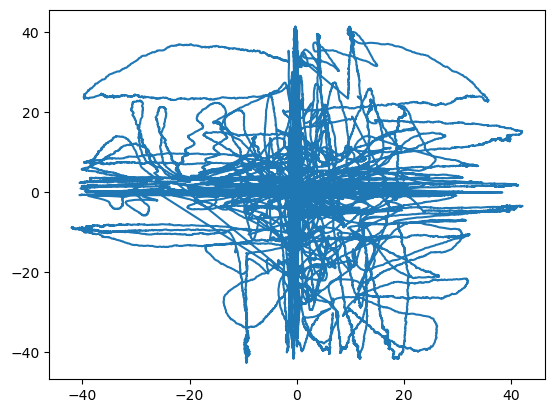

In [2]:
data = pd.read_csv('./data/lstm_disturbance.csv')
plt.plot(data['Disturbance X'], data['Disturbance Y'])

In [3]:
best_agent = PIDAgent()

best_params = {'steps_u':50, 'scaling_factor':0, 'window_distance':1000} # window distance 1000 to turn off safety leash

In [4]:
env_selector = OctorotorEnvSelector()
square_wpts = np.array([[100,0,30], [100,100,30], [0,100,30], [0,0,30]]) # you will need to define a circle trajectory the same way

In [5]:
def run_trajectory(env_selector, wind_ranges, agent, params, speed, trajectory):
    env = env_selector.get_env("lstm", params, wind_ranges, trajectory, start_alt=30, has_turbulence=True)
    
    done = False
    state = np.array(env.reset(), dtype=np.float32)
    log = DataLog(env.base_env.vehicle,
                      other_vars=('reward',))
    motor_speeds = []
    while not done:
        action = agent.predict(state, deterministic=True)[0]
        state, reward, done, info = env.step(action)
        state = np.array(state, dtype=np.float32)
        log.log(reward=reward)
        motor_speeds.append(log.vehicle.speeds)

    log.done_logging()
    return log, info, motor_speeds

`wind_ranges` will sample wind in a certain range:
- ex: [(0,5),(0,5),(0,0)] will sample 0-5 m/s in x, 0-5m/s in y, and 0 in z

If you want to fix the wind, you will need to pass something like  [(5,5),(0,0),(0,0)] for 5 m/s east wind or  [(0,0),(-5,-5),(0,0)] for 5 m/s south wind. The function below should be appropriate.

In [6]:
def sample_wind_range(magnitude):
    random_angle_degrees = np.random.uniform(0, 360)

    # Step 2: Convert the angle to radians
    random_angle_radians = np.deg2rad(random_angle_degrees)
    
    # Step 3: Calculate the components of the unit vector
    x_component = np.cos(random_angle_radians)
    y_component = np.sin(random_angle_radians)
    
    # Step 4: Create the unit vector
    unit_vector = np.array([x_component, y_component]) 
    wind_vector = unit_vector * magnitude

    wind_range = [(wind_vector[0], wind_vector[0]), (wind_vector[1], wind_vector[1]), (0,0)]
    return wind_range, wind_vector

In [7]:
sample_wind_range(3)

([(-2.87971304370912, -2.87971304370912),
  (-0.8409832256897614, -0.8409832256897614),
  (0, 0)],
 array([-2.87971304, -0.84098323]))

In [8]:
wind_range, wind_vector = sample_wind_range(3)
log, info, motor_speeds = run_trajectory(env_selector, wind_range, best_agent, best_params, 15, square_wpts)

In [9]:
info

{'reached': True,
 'outofbounds': False,
 'outoftime': False,
 'tipped': False,
 'crashed': False}

In [10]:
log.t

array([ 0.49,  0.99,  1.49,  1.99,  2.49,  2.99,  3.49,  3.99,  4.49,
        4.99,  5.49,  5.99,  6.49,  6.99,  7.49,  7.99,  8.49,  8.99,
        9.49,  9.99, 10.49, 10.99, 11.49, 11.99, 12.49, 12.99, 13.49,
       13.99, 14.41,  0.49,  0.99,  1.49,  1.99,  2.49,  2.99,  3.49,
        3.99,  4.49,  4.99,  5.49,  5.99,  6.49,  6.99,  7.49,  7.99,
        8.49,  8.99,  9.49,  9.99, 10.49, 10.99, 11.49, 11.99, 12.49,
       12.99, 13.49, 13.99, 14.3 ,  0.49,  0.99,  1.49,  1.99,  2.49,
        2.99,  3.49,  3.99,  4.49,  4.99,  5.49,  5.99,  6.49,  6.99,
        7.49,  7.99,  8.49,  8.99,  9.49,  9.99, 10.49, 10.99, 11.49,
       11.99, 12.49, 12.99, 13.49, 13.5 ,  0.49,  0.99,  1.49,  1.99,
        2.49,  2.99,  3.49,  3.99,  4.49,  4.99,  5.49,  5.99,  6.49,
        6.99,  7.49,  7.99,  8.49,  8.99,  9.49,  9.99, 10.49, 10.99,
       11.49, 11.99, 12.49, 12.99, 13.49, 13.52], dtype=float32)

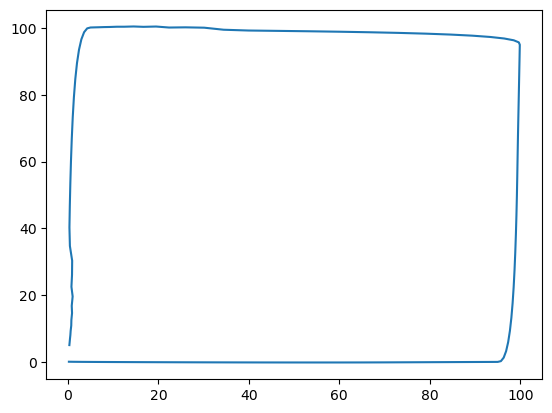

In [12]:
plt.plot(log.x, log.y) # this log should contain all the info you need for a flight

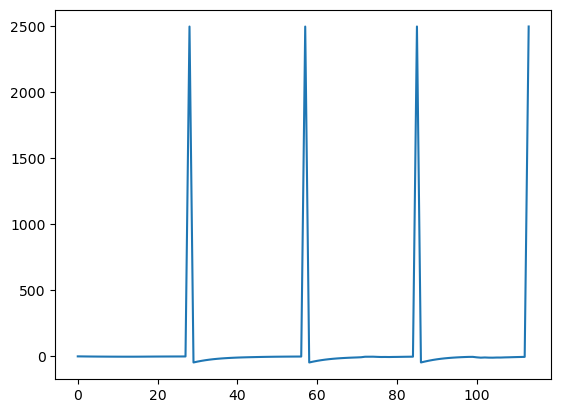

In [13]:
plt.plot(log.reward)

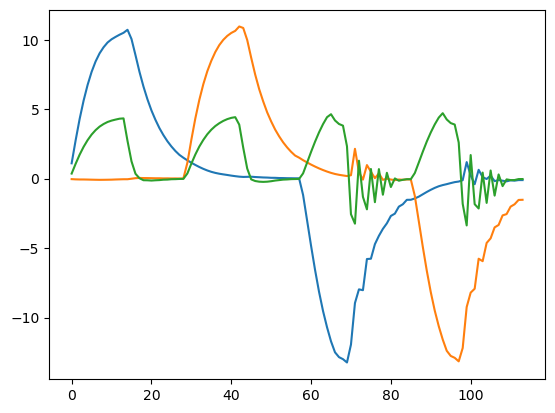

In [14]:
plt.plot(log.velocity)

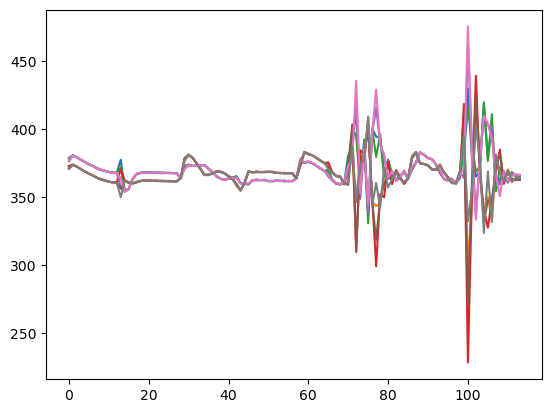

In [15]:
plt.plot(motor_speeds)

In [11]:
info

{'u': array([ 0.,  0., 30.,  0.,  0.,  0.], dtype=float32),
 'dxdt': array([ 1.5130e+00, -1.0709e+01,  2.2700e-01, -1.3830e+00,  2.2700e+00,
        -6.0730e+00,  4.0000e-03,  2.7000e-02,  3.7000e-02, -5.3000e-02,
        -7.2000e-02, -3.3000e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00], dtype=float32),
 'reached': True,
 'outofbounds': False,
 'outoftime': False,
 'tipped': False,
 'crashed': False}

In [12]:
if not info['reached']:
    print('Mission Failed')
else:
    print('Mission Success')

Mission Success
